# Objectives

We are using the UCI Heart Disease Data after wrangling in the file data/heart.csv

We will try to predict the indication of heart disease in the target variable.

In this notebook we will do predictive modeling using the pre-processed data files from the Feature Engineering notebook.

We will build models using 5 algorithms: Logistic Regression, Decision Tree, Random Forest, k Nearest Neighbor, and SVM.


# 1. Load the data from the X and y train and test files.

In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.svm          import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score

import seaborn as sns
import math

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
Xs_train = pd.read_csv('../data/Xs_train.csv')
X_test  = pd.read_csv('../data/X_test.csv')
Xs_test  = pd.read_csv('../data/Xs_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test  = pd.read_csv('../data/y_test.csv')

pd.options.display.float_format = '{:.4f}'.format
print(X_train.mean(), '\n', X_test.mean())

Age           54.2149
Sex            0.6736
ChestPain      2.7934
SystolicBP   130.9504
Chol         246.0000
Glucose        0.1529
RestECG        0.4876
STMaxRate    151.0661
STPain         0.2934
STWave         0.9752
NumColor       0.6281
STSlope_1      0.4628
STSlope_2      0.4711
Defects_1      0.0496
Defects_2      0.5744
Defects_3      0.3678
dtype: float64 
 Age           54.9672
Sex            0.7213
ChestPain      3.0984
SystolicBP   134.2951
Chol         247.3115
Glucose        0.1311
RestECG        0.5574
STMaxRate    144.0164
STPain         0.4590
STWave         1.1475
NumColor       0.8033
STSlope_1      0.4590
STSlope_2      0.4590
Defects_1      0.0984
Defects_2      0.4426
Defects_3      0.4590
dtype: float64


In [4]:
## Make y's into Series, not DataFrames, to silence model warnings.
y_train = y_train['AngioTgt']
y_test  = y_test['AngioTgt']

### Data check

The means of our train and test sets are not exactly identical, which is fine since the test set is meant to show how the model responds to new data.  The test set has a higher proportion of males, subjects with ChestPain, higher SystolicBP, RestECG, STPain, STWave, NumColor and Defects values 1 and 3.  The test set subjects have a lower average STMaxRate and Defects value 2.  

In [5]:
print(Xs_train.mean(), '\n', Xs_test.mean())

Age_SS           0.0000
Sex              0.6736
ChestPain        2.7934
SystolicBP_SS    0.0000
Chol_SS         -0.0000
Glucose          0.1529
RestECG          0.4876
STMaxRate_SS    -0.0000
STPain           0.2934
STWave           0.9752
NumColor         0.6281
STSlope_1        0.4628
STSlope_2        0.4711
Defects_1        0.0496
Defects_2        0.5744
Defects_3        0.3678
dtype: float64 
 Age_SS           0.0000
Sex              0.7213
ChestPain        3.0984
SystolicBP_SS   -0.0000
Chol_SS         -0.0000
Glucose          0.1311
RestECG          0.5574
STMaxRate_SS    -0.0000
STPain           0.4590
STWave           1.1475
NumColor         0.8033
STSlope_1        0.4590
STSlope_2        0.4590
Defects_1        0.0984
Defects_2        0.4426
Defects_3        0.4590
dtype: float64


### Scaled data check

Our standardized scaling looks good.  All four features (Age, SystolicBP, Chol and STMaxRate) have 0 means as they should.  Our unscaled numbers match, as they should.

### Reusable python code

In [5]:
def plot_confusion(title, model, x, y, score):
    
    predictions = model.predict(x)
    cm = confusion_matrix(y, predictions)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = title + '\nAccuracy Score: {0}%\nRsquared = {1}'\
        .format(round(100*score, 1), round(r2_score(y, predictions),3))
    plt.title(all_sample_title, size = 15);
    print(classification_report(y, predictions))
    plot_roc_curve(model, x, y);
    

class Attribution():
    df = pd.DataFrame()
    
    def __init__ (self, model, features, coeffs, mod=None):
        self.model_name = model
        self.list = zip(features, coeffs)
        if not mod:
            mod = model
        rows=[model, mod + "_rank"]
        newrows = pd.DataFrame(index=rows)
        i=1
        for (f, c) in iter(sorted(self.list, key= lambda y : abs(y[1]), reverse=True)):
            newrows[f] = ('{:.2f}'.format(np.round(c, 2)), int(i))
            i += 1
        Attribution.df.drop(index=rows, errors='ignore', inplace=True)
        Attribution.df = pd.concat([Attribution.df, newrows])

    def report (self, rows=None):
        if rows:
            return Attribution.df.loc[rows].transpose()
        return Attribution.df.transpose()
    
    def printout (self):
        print("\n{} Coefficients:".format(self.model_name))
        for f, imp in iter(sorted(self.list, key= lambda y : abs(y[1]), reverse=True)):
            print("{:13s} {:5.2f}".format(f, np.round(imp, 2)))
            
    

# 2. Logistic Regression

We will use the unscaled training and test sets for a Logistic Regression algorithm.

C:\Users\bradd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8512396694214877 0.8688524590163934
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        32
           1       0.92      0.79      0.85        29

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



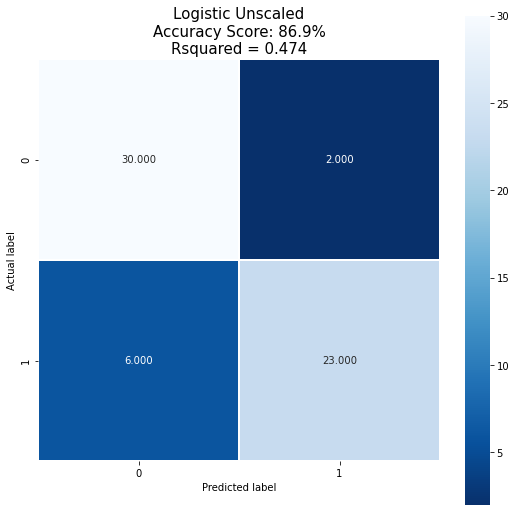

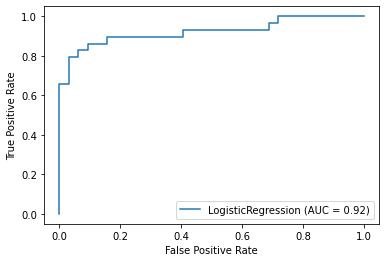

In [6]:
LogReg = LogisticRegression(max_iter=1000)

LogReg.fit(X_train, y_train)

train_score = LogReg.score(X_train, y_train)
score = LogReg.score(X_test, y_test)

print (train_score, score)
plot_confusion("Logistic Unscaled", LogReg, X_test, y_test, score)

att = Attribution('LogReg', X_test.columns, LogReg.coef_[0], 'LR')


0.8471074380165289 0.8688524590163934
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.89      0.83      0.86        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



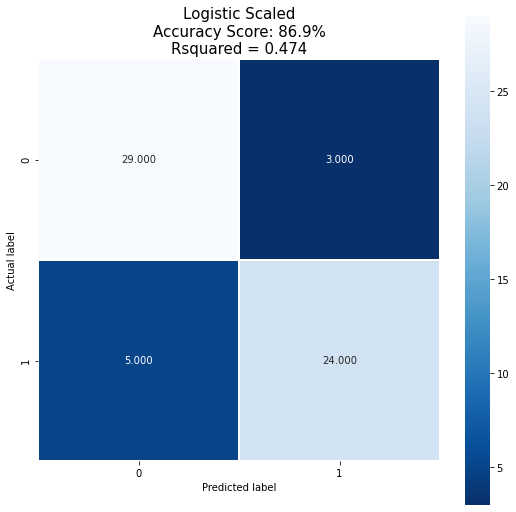

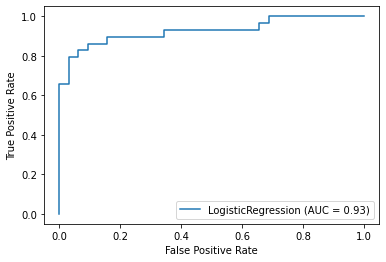

In [7]:
## The algorithm doesn't converge, even after bumping max_iter up from 100 to 1000.  Use the scaled data.
## Despite not converging, the accuracy isn't bad, 86.9%, which is actually HIGHER than the accuracy against the training set.

LogReg.fit(Xs_train, y_train)

train_score = LogReg.score(Xs_train, y_train)
score = LogReg.score(Xs_test, y_test)

print (train_score, score)
plot_confusion("Logistic Scaled", LogReg, Xs_test, y_test, score)
att = Attribution('LogRegScaled', Xs_test.columns, LogReg.coef_[0], 'LRs')


### Logistic Regression Scores

The algorithm converged using the scaled data.  The accuracy is exactly the same as reported by the uncoverged algorithm against the unscaled data:  86.9%.   The training set accuracy went down slightly from 85.1% to 84.7%.  

In the confusion matrix, exactly one case moved from predicted 0 in the Unscaled run to 1 in Scaled for each row (actual = 0 and 1).  Rsquared is the same for both, 0.474.  F1 nudged from (.88, .85) to (.88, .86) with scaling. AUC nudged from 92% to 93%.

Not a bad start.  Let's compare against other algorithms.




# 3. Decision Tree

Let's try a simple decision tree before running a Random Forest.

1.0 0.7704918032786885
9 46
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.83      0.66      0.73        29

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61

1.0 0.819672131147541
9 46
[0.08775877 0.         0.1796221  0.08986978 0.05556997 0.
 0.05231918 0.05376472 0.0137093  0.03462453 0.1306718  0.02853774
 0.00895302 0.         0.25340783 0.01119127]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.82      0.79      0.81        29

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



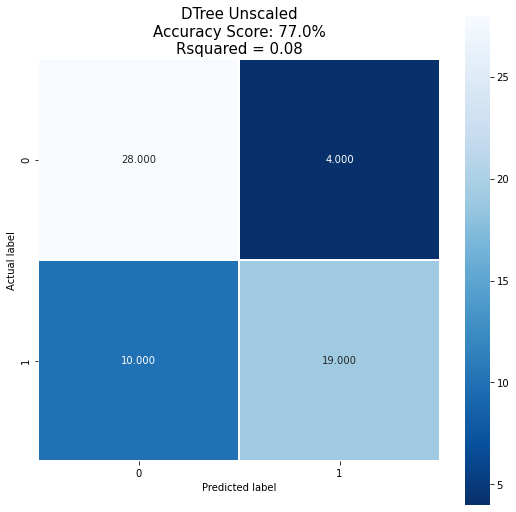

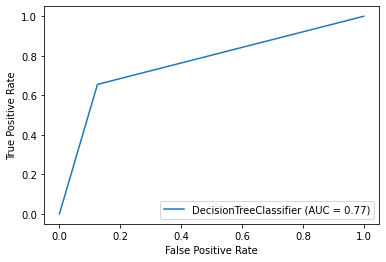

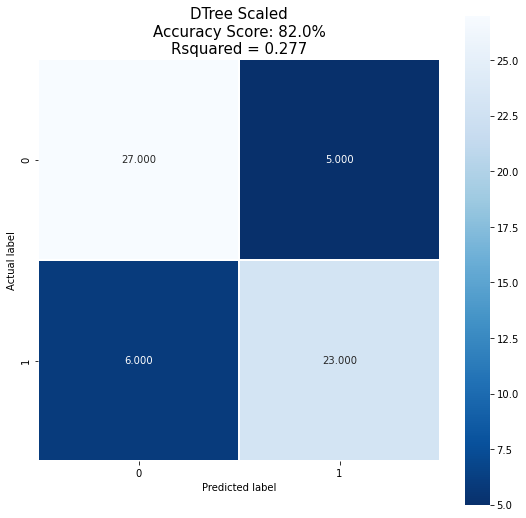

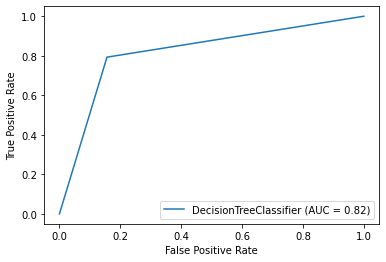

In [8]:
DTree = DecisionTreeClassifier(random_state = 21)
DTree.fit(X_train, y_train)

train_score = DTree.score(X_train, y_train)
score = DTree.score(X_test, y_test)

print (train_score, score)
print(DTree.get_depth(), DTree.get_n_leaves())
plot_confusion("DTree Unscaled", DTree, X_test, y_test, score)
att = Attribution('DTree', X_test.columns, DTree.feature_importances_, 'DT')

## Try the scaled data
DTree.fit(Xs_train, y_train)

train_score = DTree.score(Xs_train, y_train)
score = DTree.score(Xs_test, y_test)

print (train_score, score)
print(DTree.get_depth(), DTree.get_n_leaves())
print(DTree.feature_importances_)
plot_confusion("DTree Scaled", DTree, Xs_test, y_test, score)
att = Attribution('DTreeScaled', Xs_test.columns, DTree.feature_importances_, 'DTs')

### Decision Tree Score

Scaling definitely helped this Decision Tree model.  The accuracy is better using the scaled data: 82.0%, up from 77.0% using the unscaled data.  The Rsq shows a dramatic improvement from 0.08 to 0.277.  F1 increases from (.80, .73) to (.83, .81) The confusion matrix has fewer false predictions and is better in the lower right (1, 1).  AUC increases from 77% to 82%.

Scaling shouldn't matter to a Decision Tree.  In fact, the Feature Importances are almost identical between scaled and unscaled data (see print below).  Only two scaled parameters flipped in importance when scaled.  Age and Chol swapped places 5 and 6.  However, 4 of the Actual 1s went from Predicted 0 to Predicted 1 thanks to the scaling, while we lost 1 Actual 0 in our scaled prediction.

This Decision Tree is still inferior to the Logistic Regression.  Logistic beats the Decision Tree 86.9% vs. 82% accuracy, 0.474 vs. 0.277 Rsquared, and (.88, .86) to (.83, .81) F1.

### Decision Tree Feature Importance

In [9]:
att.report(['DTree','DT_rank','DTreeScaled','DTs_rank'])

,DTree,DT_rank,DTreeScaled,DTs_rank
NumColor,0.13,3,0.13,3
Sex,0.00,14,0.00,14
STPain,0.01,11,0.01,11
Defects_2,0.25,1,0.25,1
Defects_3,0.01,12,0.01,12
STSlope_1,0.03,10,0.03,10
Glucose,0.00,15,0.00,15
Defects_1,0.00,16,0.00,16
ChestPain,0.18,2,0.18,2
STSlope_2,0.01,13,0.01,13


The Decision Tree paints quite a different picture of feature importance than did Logistic Regression.  It says Defects value 2 is most important at 0.25, followed by ChestPain at 0.18 and NumColor at 0.13.

# 4. Random Forest

Now the Random Forest model.

The Decision Tree went to a depth of 9.  Let's run Random Forest at that depth once with defaults for other parameters before we tune the typical hyperparameters with Cross Validation.

1.0 0.8360655737704918
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.82        29

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



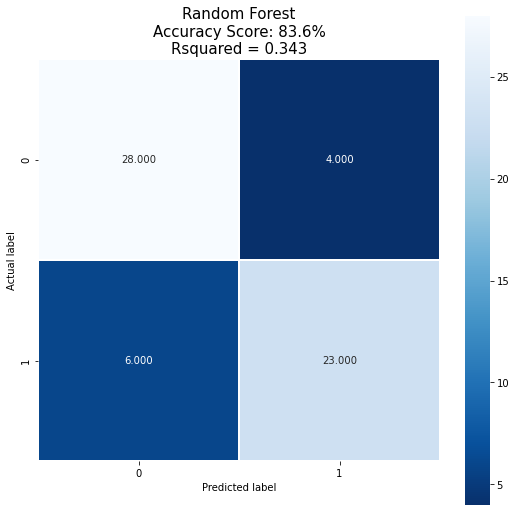

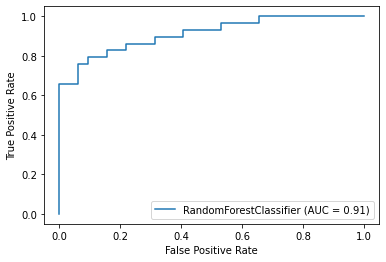

In [10]:
RF = RandomForestClassifier(max_depth=9, random_state = 21)
RF.fit(X_train, y_train)

train_score = RF.score(X_train, y_train)
score = RF.score(X_test, y_test)

print (train_score, score)
print(RF.get_params())

plot_confusion("Random Forest", RF, X_test, y_test, score)
att = Attribution('RF0', X_test.columns, RF.feature_importances_)


Random Forest with max_depth of 9 fared somewhat better than DecisionTree.

* RF shows 83.6% Acc, 0.343 R^2, 85% precision, 79% recall, (.85, .82) F1 and 91% AUC 
* vs. 
* DTree (scaled): 82%, .277 R^2, 82% precision, 79% recall, (.83, .81) F1 and 82% AUC

Let's try it with cross-validation.

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1512 out of 1512 | elapsed:  3.2min finished


0.9380165289256198 0.819672131147541
Best Score:0.8430555555555556
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 125}
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.82      0.79      0.81        29

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



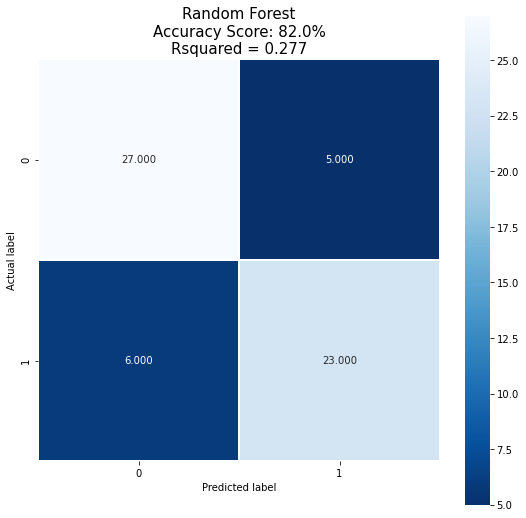

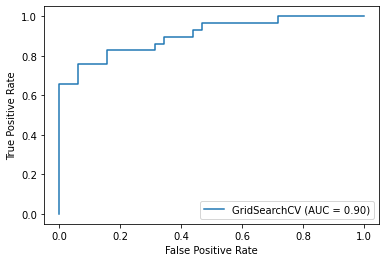

In [11]:
param_grid = {'n_estimators':np.arange(25,176,25), 'criterion':['gini', 'entropy'], 'max_depth':[5,9,10,15],
              'min_samples_split':[2,3,5], 'max_features':[3,5,10]}

rfc = RandomForestClassifier(random_state=21)
rfc_cv= GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1, verbose=3, return_train_score=True)
rfc_cv.fit(X_train, y_train)
train_score = rfc_cv.score(X_train, y_train)
score = rfc_cv.score(X_test, y_test)

print (train_score, score)
print("Best Score:" + str(rfc_cv.best_score_))
print("Best Parameters: " + str(rfc_cv.best_params_))


plot_confusion("Random Forest", rfc_cv, X_test, y_test, score)
att = Attribution('RFcv1', X_test.columns, rfc_cv.best_estimator_.feature_importances_)


This grid search produced a Random Forest that improved on the original RF by some measures and declined in others.  Let's adjust the parameter grid to bracket this solution and try again.

In [37]:
param_grid2 = {'n_estimators':[75,80,100,120,125,130,150], 'criterion':['entropy','gini'], 'max_depth':[4,5,9],
               'min_samples_split':[2,3,5],'max_features':[3,4,5,10]}

rf2 = RandomForestClassifier(random_state=21)
rf2_cv= GridSearchCV(rf2, param_grid2, cv=3, n_jobs=-1, verbose=3, return_train_score=True)
rf2_cv.fit(X_train, y_train)
train_score = rf2_cv.score(X_train, y_train)
score = rf2_cv.score(X_test, y_test)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1512 out of 1512 | elapsed:  3.4min finished


0.9421487603305785 0.8032786885245902
Best Score:0.8430555555555556
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 120}
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        32
           1       0.81      0.76      0.79        29

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



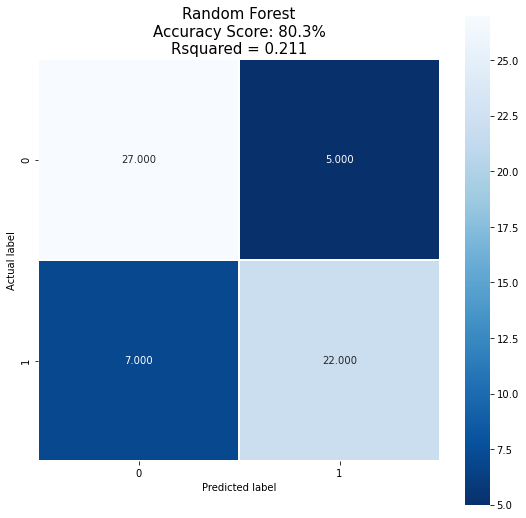

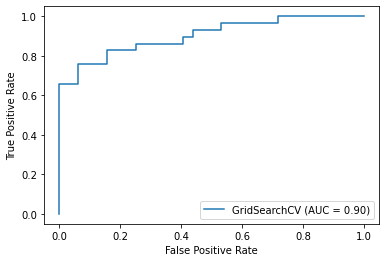

In [38]:
print (train_score, score)
print("Best Score:" + str(rf2_cv.best_score_))
print("Best Parameters: " + str(rf2_cv.best_params_))
att = Attribution('RFcv2', X_test.columns, rf2_cv.best_estimator_.feature_importances_)

plot_confusion("Random Forest", rf2_cv, X_test, y_test, score);

Ok, so we ran this more than once, following n trees as it grew and max features as it shrunk.  The sensitivity to hyper-parameters is quite low.  We've found a number of "best" solutions, depending upon the grid we entered, and most of them have nearly identical fit metrics.

We finally settled on Entropy, 120 Trees, Max Depth 4, Min Samples 2, Max Features 3 (involved in each split, nominally sqrt(n features) which is about 3.6 for our 13 features).  This edged out the first cross-validation result 91% to 89% in ROC AUC, and matched it exactly on all other metrics.

Logistic also beats the Random Forest! 86.9% vs. 83.6% accuracy, 0.474 vs. 0.343 Rsquared, (.88, .86) to (.84, .83) F1, and 93% to 91% on ROC AUC.

# 5. K Nearest Neighbors

Moving on to K Nearest Neighbors.

9 0.7049180327868853

 Train Accuracy      Test Accuracy
7 0.756198347107438 0.6885245901639344
9 0.7355371900826446 0.7049180327868853
11 0.6900826446280992 0.7049180327868853
13 0.71900826446281 0.6885245901639344
17 0.6983471074380165 0.6885245901639344
19 0.6859504132231405 0.7049180327868853


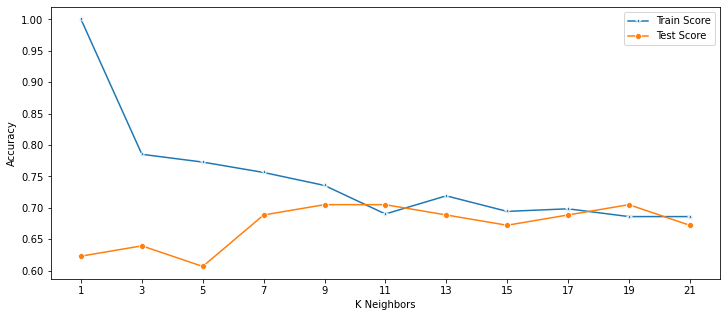

In [12]:
## Start with KNeighborsClassifer with sklearn's defaults and varying n neighbors from 1 to 9, odd numbers only.  
##  Make that 21, as it was still getting better at 9.

## Try it on the unscaled data, for comparison's sake.  The scaled data should be better.
test_scores = []
train_scores = []

for i in range(1,22,2):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
    
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,22,2), y=train_scores, marker='*',label='Train Score')
p = sns.lineplot(x=range(1,22,2), y=test_scores, marker='o',label='Test Score')
p.set_xlabel('K Neighbors')
p.set_ylabel('Accuracy')
p.set(xticks=range(1,22,2))

maximum = max(test_scores)
print(2*test_scores.index(maximum)+1, maximum)

print('\n','Train Accuracy','     Test Accuracy')
i=0
for t in test_scores:
    if (t > maximum - .02): print(2*i +1, train_scores[i], t, )
    i+=1

As we increase k, the Nearest Neighbors classifier gets less picky and we tend to underfit.  
The test score crosses the training score at 11 and 19, but on either side of each point the training score beats the test score.
As we increase k past 11, the test score falls off.  
We'll take the maximum test score, 70.5% at k=9.

Note, this is considerably worse than Logistic Regression or Random Forest.
Now let's see how Nearest Neighbors does against properly scaled data.

13 0.8524590163934426

 Train Accuracy      Test Accuracy
5 0.8801652892561983 0.8360655737704918
11 0.8429752066115702 0.8360655737704918
13 0.8347107438016529 0.8524590163934426
15 0.8181818181818182 0.8524590163934426
17 0.8388429752066116 0.8524590163934426
19 0.8429752066115702 0.8524590163934426
21 0.8347107438016529 0.8524590163934426


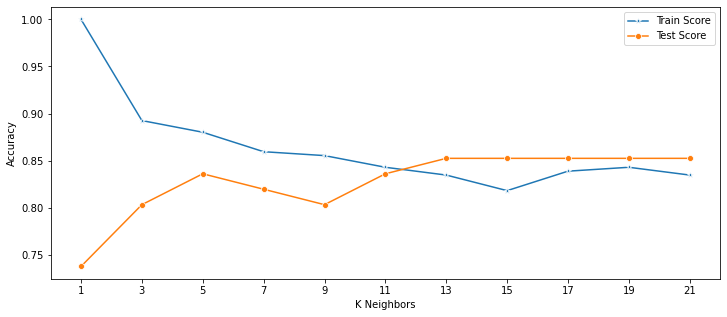

In [33]:
test_scores = []
train_scores = []

for i in range(1,22,2):

    knn = KNeighborsClassifier(i, n_jobs=-1)
    knn.fit(Xs_train,y_train)
    
    train_scores.append(knn.score(Xs_train,y_train))
    test_scores.append(knn.score(Xs_test,y_test))
    
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,22,2), y=train_scores, marker='*',label='Train Score')
p = sns.lineplot(x=range(1,22,2), y=test_scores, marker='o',label='Test Score')
p.set_xlabel('K Neighbors')
p.set_ylabel('Accuracy')
p.set(xticks=range(1,22,2))

maximum = max(test_scores)
print(2*test_scores.index(maximum)+1, maximum)
print('\n','Train Accuracy','     Test Accuracy')
i=0
for t in test_scores:
    if (t > maximum - .02): print(2*i +1, train_scores[i], t, )
    i+=1

Much better!

The best k moves to 13 and the test score is now 85.2%, matching the best Random Forest.

Above 13, the test score holds steady at 85.2%, probably because of the small size of the test data, while the training score continues to remain below it.

We will try cross-validation.  We will only vary k, the same as we did with a loop above, but we'll see if the cross validation using folds of the training data makes a difference itself.

In [34]:
param_grid = {'n_neighbors':np.arange(1,22,2)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn, param_grid, cv=5, return_train_score=True, n_jobs=-1)
knn_cv.fit(Xs_train,y_train)

print("Train Score:" + str(knn_cv.score(Xs_train, y_train)))
print("Test Score:" + str(knn_cv.score(Xs_test, y_test)))

Train Score:0.8347107438016529
Test Score:0.8524590163934426


Looks the same at 85.2%.

Let's look at the Confusion Matrix for the best kNN model.

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.86      0.83      0.84        29

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



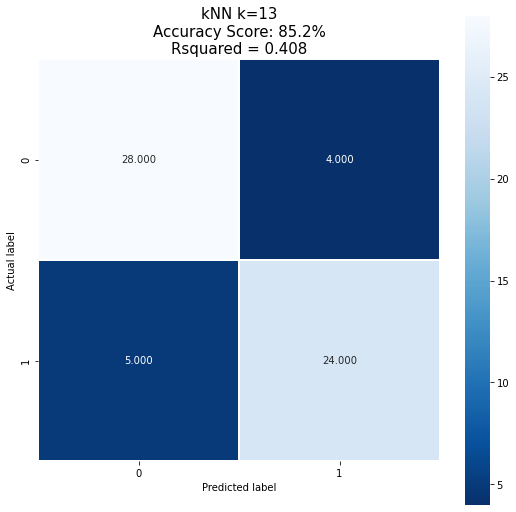

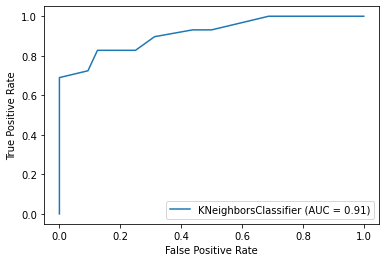

In [35]:
knn = KNeighborsClassifier(13)
knn.fit(Xs_train,y_train)
    
train_score = knn.score(Xs_train,y_train)
score = knn.score(Xs_test,y_test)
plot_confusion("kNN k=13", knn, Xs_test, y_test, score)


# 5. Support Vector Machine

The trees and kNN did not beat Logistic Regression.  Let's try an SVM classifier.

0.8842975206611571 0.8524590163934426
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 21, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.86      0.83      0.84        29

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



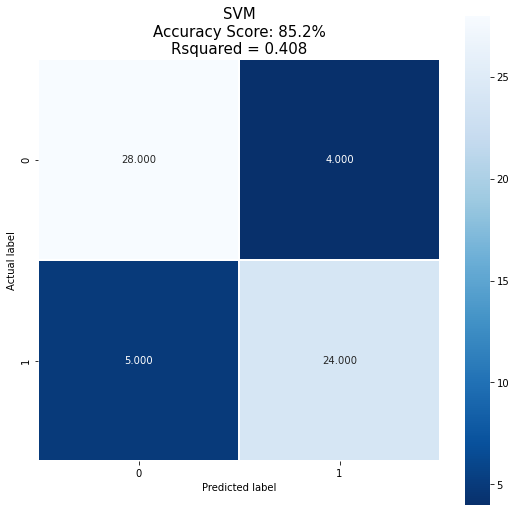

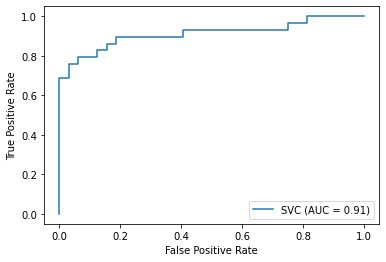

In [33]:
SVM = SVC(random_state = 21)
SVM.fit(Xs_train, y_train)

train_score = SVM.score(Xs_train, y_train)
score = SVM.score(Xs_test, y_test)

print (train_score, score)
print(SVM.get_params())

plot_confusion("SVM", SVM, Xs_test, y_test, score)

We'll run the Linear SVM so that we can get coefficients for the features.  It's performance turns out slightly less than the RBF kernel.

0.8512396694214877 0.8360655737704918
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 21, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.83      0.83      0.83        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



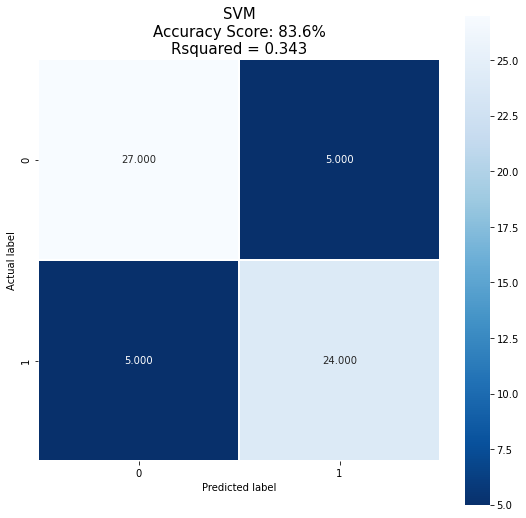

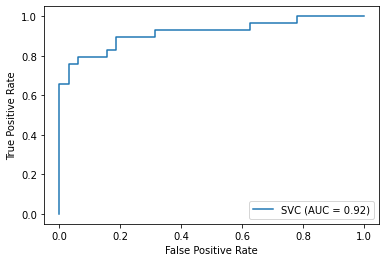

In [34]:
SVM = SVC(kernel='linear',random_state = 21)
SVM.fit(Xs_train, y_train)

train_score = SVM.score(Xs_train, y_train)
score = SVM.score(Xs_test, y_test)

print (train_score, score)
print(SVM.get_params())
att = Attribution('SVM', Xs_test.columns, SVM.coef_[0])

plot_confusion("SVM", SVM, Xs_test, y_test, score)

This SVM model scores exactly the same as the kNN(13) model.

We'll go with the Logistic Regression (against scaled data) as the best model.  

# 6. Feature Attribution / Importance

kNN cannot provide any indication of the relative importance of features.  SVM can only if you use the linear kernel.  Here is a look at the feature importances we collected.


In [35]:
att.report()

,LogReg,LR_rank,LogRegScaled,LRs_rank,DTree,DT_rank,DTreeScaled,DTs_rank,RF0,RF0_rank,RFcv1,RFcv1_rank,RFcv2,RFcv2_rank,SVM,SVM_rank
NumColor,-1.19,1,-1.18,1,0.13,3,0.13,3,0.14,1,0.14,1,0.14,1,-0.81,1
Sex,-1.12,2,-1.07,2,0.00,14,0.00,14,0.03,13,0.03,11,0.02,13,-0.43,7
STPain,-0.96,3,-1.00,3,0.01,11,0.01,11,0.06,10,0.07,7,0.07,6,-0.77,2
Defects_2,0.78,4,0.72,5,0.25,1,0.25,1,0.09,4,0.10,4,0.11,3,0.75,3
Defects_3,-0.71,5,-0.79,4,0.01,12,0.01,12,0.08,5,0.10,5,0.10,5,-0.45,6
STSlope_1,-0.68,6,-0.68,6,0.03,10,0.03,10,0.03,11,0.02,13,0.04,11,-0.55,5
Glucose,0.56,7,0.52,7,0.00,15,0.00,15,0.01,15,0.01,15,0.01,15,0.38,8
Defects_1,0.53,8,0.39,9,0.00,16,0.00,16,0.00,16,0.00,16,0.00,16,0.69,4
ChestPain,-0.36,9,-0.36,10,0.18,2,0.18,2,0.11,2,0.13,2,0.13,2,-0.17,12
STSlope_2,0.33,10,0.32,11,0.01,13,0.01,13,0.03,12,0.03,12,0.05,10,0.22,10


## Relative Importance of Diagnostic Tests

1. Except for Decision Trees, all the models put NumColor as the most important feature.  This makes sense because the target measure of heart disease is the narrowing of the cardiac artery via angiogram.  The coloration is another way to measure the narrowing of 4 arteries in the area.

2. Logistic Regression, which is our best fitting model, puts Sex (M=1) at the 2nd most important, with male subjects less likely to have the target than the female subjects.  The other models show Sex as one of the least important.

3. Logistic counts STPain (during the stress test) as the 3rd most important, the Linear Support Vector Machine puts it at 2nd.  All the tree-based models rank it middling to low.

4. Defects 2 and 3 (Fixed or Reversible Defect) come in 4th and 5th or better in most of the models.

5. Chest Pain (in general, not during the stress test) comes in 2nd in all the models, except Logistic (9th or 10th) and SVM (12th).

6. None of the other features really stands out.

7. Scaling of the 4 numeric features (STMaxRate, SystolicBP, Chol and Age) does not affect their ranking much in the two models which we ran with scaled and unscaled data (Logistic and Decision Tree).
